In [2]:
import os
from pycocotools.coco import COCO
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-base-patch4-window8-256",
    image_model_train=False,
    language_model_name="google/flan-t5-base",
    ffn=True,
    transformer_model_name="google/flan-t5-small",
    max_source_length=256,
    max_target_length=128,
    # Dir setting
    data_dir="/data/dataset/imagenet_2012",
    result_dir="/home/jikuya/KLab_MultiModalModel/results/image_classify/only_transformer_small/google/flan-t5-small",
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
model = MyModel(args).to(device)
model.load(result_name='best.pth')

In [8]:
from transformers import AutoTokenizer
from torchvision import transforms
tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=512)
resize=256
transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])

# COCO

In [113]:
# Load COCO
phase = 'train'
anno_path = os.path.join(args.data_dir, 'annotations', f'captions_{phase}2017.json')
coco = COCO(anno_path)
img_dir = os.path.join(args.data_dir, f'{phase}2017')

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


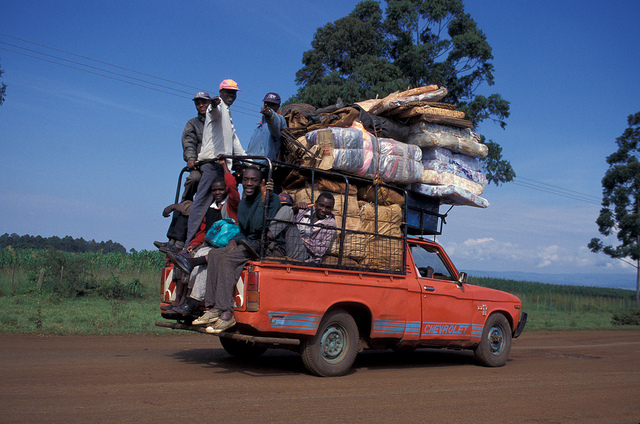

GT: A group of people riding on the back of a loaded red pickup truck.
Pred: A group of people riding on the back of a loaded red pickup truck.


In [114]:
for i, image_id in enumerate(coco.getImgIds()):
    if i != 20:
        continue
    image_info = coco.loadImgs(image_id)[0]
    img_name = image_info['file_name']
    img_path = os.path.join(img_dir, img_name)

    caption = coco.loadAnns(coco.getAnnIds(image_id))[0]['caption']
    break

image = Image.open(img_path).convert('RGB')
display(image)
transform = ToTensor()
image = transform(image.resize((256,256)))
src_text = 'What does the image describe ?'
with torch.no_grad():
    processed_image = image_processor(image, return_tensors="pt").to(device)
    source_encoding = tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt').to(device)
    output = model(processed_image, source_encoding, return_loss=False)
print(f'GT: {caption}')
print(f'Pred: {tokenizer.decode(output[0], skip_special_tokens=True)}')

# ImageNet

In [9]:
map_clsloc_path = os.path.join(args.data_dir, 'map_clsloc.txt')
imagenet_classes = {}
with open(map_clsloc_path, 'r') as f:
    for line in f.readlines():
        line = line.strip().split(' ')
        imagenet_classes[line[2]] = line[0]
imagenet_classes.keys()

dict_keys(['kit_fox', 'English_setter', 'Siberian_husky', 'Australian_terrier', 'English_springer', 'grey_whale', 'lesser_panda', 'Egyptian_cat', 'ibex', 'Persian_cat', 'cougar', 'gazelle', 'porcupine', 'sea_lion', 'malamute', 'badger', 'Great_Dane', 'Walker_hound', 'Welsh_springer_spaniel', 'whippet', 'Scottish_deerhound', 'killer_whale', 'mink', 'African_elephant', 'Weimaraner', 'soft-coated_wheaten_terrier', 'Dandie_Dinmont', 'red_wolf', 'Old_English_sheepdog', 'jaguar', 'otterhound', 'bloodhound', 'Airedale', 'hyena', 'meerkat', 'giant_schnauzer', 'titi', 'three-toed_sloth', 'sorrel', 'black-footed_ferret', 'dalmatian', 'black-and-tan_coonhound', 'papillon', 'skunk', 'Staffordshire_bullterrier', 'Mexican_hairless', 'Bouvier_des_Flandres', 'weasel', 'miniature_poodle', 'Cardigan', 'malinois', 'bighorn', 'fox_squirrel', 'colobus', 'tiger_cat', 'Lhasa', 'impala', 'coyote', 'Yorkshire_terrier', 'Newfoundland', 'brown_bear', 'red_fox', 'Norwegian_elkhound', 'Rottweiler', 'hartebeest', '

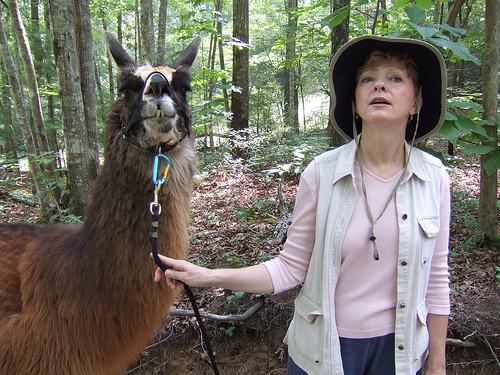

GT: a photo of llama, Pred: a photo of llama


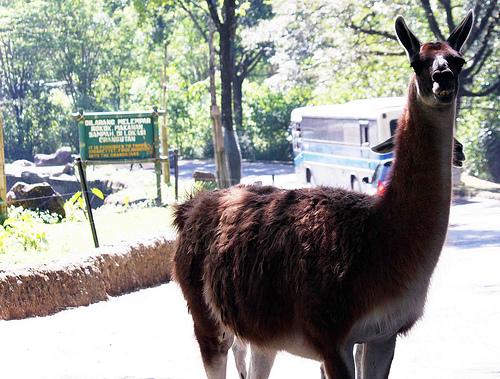

GT: a photo of llama, Pred: a photo of llama


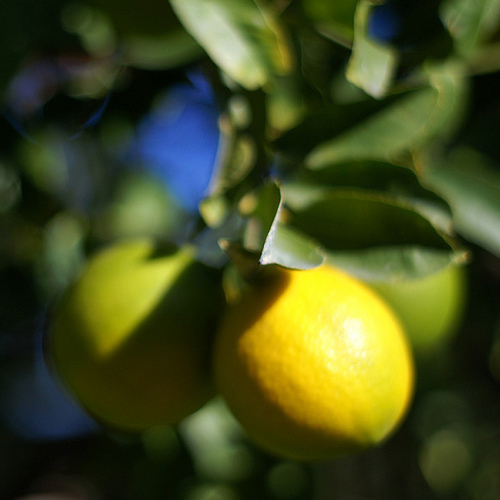

GT: a photo of lemon, Pred: a photo of lemon


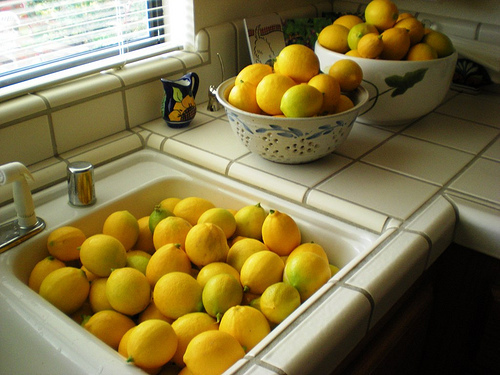

GT: a photo of lemon, Pred: a photo of lemon


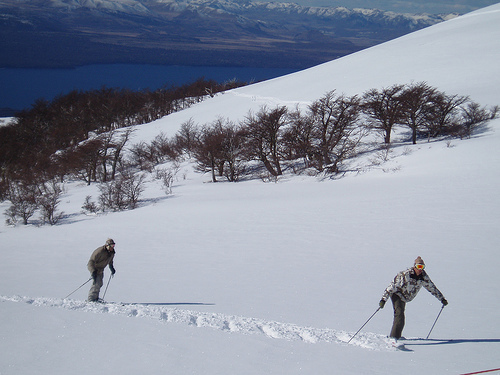

GT: a photo of ski, Pred: a photo of ski


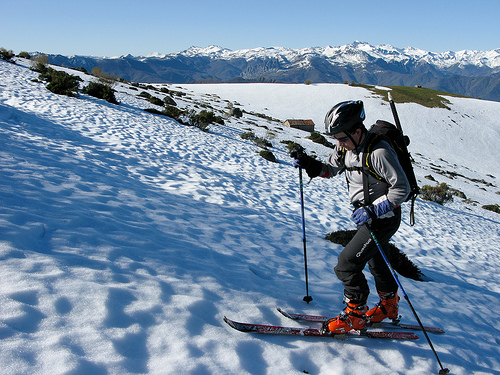

GT: a photo of ski, Pred: a photo of ski
{'llama': [50, 50], 'lemon': [50, 50], 'ski': [50, 50]}


In [12]:
targets = ['llama', 'lemon', 'ski']
mode = 'val'

results = {}
for target in targets:
    target_folder = os.path.join(args.data_dir, f'ILSVRC2012_img_{mode}', imagenet_classes[target])
    for i, img_name in enumerate(os.listdir(target_folder)):
        img_path = os.path.join(target_folder, img_name)
        ori_image = Image.open(img_path).convert('RGB')
        image = transforms(ori_image).unsqueeze(0).to(device)
        src_text = 'What does the image describe ?'
        with torch.no_grad():
            src_text = tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device)
            output = model(image, src_text, return_loss=False)
            gt = f'a photo of {target}'
            pred = tokenizer.decode(output[0], skip_special_tokens=True)
        
        if target not in results:
            results[target] = [0, 0]
        results[target][0] += 1
        if gt == pred:
            results[target][1] += 1
        if i < 2:
            display(ori_image)
            print(f'GT: {gt}, Pred: {pred}')
print(results)